Here we will build a connectivity analysis pipeline for the KPE study. 
Methods should be easily generalized for others studies. 


In [2]:
## Use this box if you want MDSL
# using MSDL atlas - Can choose different atlas or different nodes (using ICA or something else)
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()

# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
#labels_img=yeo['thick_17']
labels =  atlas['labels']
coords = atlas.region_coords# grab center coordinates for atlas labels
#coords = plotting.find_parcellation_cut_coords(labels_img=labels)
#atlas.region_coords

# optional set of different atlas
#atlas_yeo_2011 = 
#atlas_yeo = atlas_yeo_2011.thick_7

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [ ]:
labels

In [ ]:
# Run either this or MSDL - not both boxes
# try to use Shen atlas
import pandas as pd

atlas_filename = '/home/oad4/nilearn_data/shenParcellation/shen_2mm_268_parcellation.nii.gz'
atlas_labes = pd.read_csv('/home/oad4/nilearn_data/shenParcellation/shen_268_parcellation_networklabels.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

atlas_labes = np.array(atlas_labes)
atlas_labes

In [3]:
import os
import numpy as np

In [4]:
# methods
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf', 'white_matter', 'framewise_displacement',
                          'a_comp_cor_00', 'a_comp_cor_01',	'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 
                        'a_comp_cor_05', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']] # can add 'global_signal' also
     # change NaN of FD to zero
    finalConf = np.array(finalConf)
    finalConf[0,2] = 0
    return finalConf

In [12]:
# build method for creating time series for subjects
def timeSeries(func_files, confound_files):
    total_subjects = [] # creating an empty array that will hold all subjects matrix 
    # This function needs a masker object that will be defined outside the function
    for func_file, confound_file in zip(func_files, confound_files):
        print(f"proccessing file {func_file}") # print file name
        confoundClean = removeVars(confound_file)
        confoundArray = confoundClean#confoundClean.values
        time_series = masker.fit_transform(func_file, confounds=confoundArray)
        #time_series = extractor.fit_transform(func_file, confounds=confoundArray)
        #masker.fit_transform(func_file, confoundArray)
        total_subjects.append(time_series)
    return total_subjects

# contrasting two timePoints
def contFuncs(time_series1, time_series2):
    twoMinusOneMat = []
    for scanMatrix, scanMatrix2 in zip(time_series1, time_series2):
        a = scanMatrix2 - scanMatrix
        twoMinusOneMat.append(a)
    return np.array(twoMinusOneMat)

import numpy as np
from nilearn import plotting

# create correlation matrix per subject
def createCorMat(time_series):
    # create correlation matrix for each subject
    fullMatrix = []
    for time_s in time_series:
        correlation_matrix = correlation_measure.fit_transform([time_s])[0]
        fullMatrix.append(correlation_matrix)
    return fullMatrix

# create connecotme graph per subject
def connectome_graph (fullMatrix):
    # here it is set to threshold 1%
    for matrix in fullMatrix:
        plotting.plot_connectome(matrix, coords,
                             edge_threshold="99%", colorbar=True)
        plotting.show()

In [6]:
# Here you set the specific methods for masking and correlation. Please see Nilearn website for more info.

from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
# in this mask we standardize the values, so mean is 0 and between -1 to 1
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, smoothing_fwhm = 6,
                         memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)

# use different masker when using Yeo atlas. 
#masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,smoothing_fwhm = 6,
 #                        memory="/home/oad4/scratch60/nilearn",high_pass=.01 , low_pass = .1, t_r=1, verbose=5)
                           
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='partial correlation') # can choose partial - it might be better


In [7]:
# now we call subjcets
# and start the real analysis
subList =  ['008','1293','1307','1322','1339','1343','1387','1223']
midSubList = ['1253','1263','1351','1364','1369','1390','1403']

# these two functions take subject list and session number (in string) and return func file list and confound file list
def fileList(subjects, session):
    func_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % (sub,session,sub,session) for sub in subjects]
    return func_files

def confList(subjects, session):
    confound_files = ['/home/oad4/scratch60/kpeOutput/fmriprep/sub-%s/ses-%s/func/sub-%s_ses-%s_task-rest_desc-confounds_regressors.tsv' % (sub,session,sub,session) for sub in subjects]
    return confound_files


In [9]:
# now we call for the functions for each set.
# for every time line we want to run time series and then contrast between the times
ket1_series = timeSeries(func_files=fileList(subList,'1'), confound_files=confList(subList, '1'))

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Resampling maps
[Memory]0.1s, 0.0min    : Loading resample_img...


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/home/oad4/scratch60/nilearn'", use "location='/home/oad4/scratch60/nilearn'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is curre

________________________________________resample_img cache loaded - 0.5s, 0.0min
[Memory]1.2s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]15.2s, 0.3min   : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-1/func/sub-1307_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'maps_img': '/home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  't_r': 1,
  'target_affine': None,
  'target_shape': None}, confounds=array([[4.930121e+03, ..., 0.000000e+00],
       ...,
       [4.805745e+03, ..., 3.336500e-04]]), dtype=None, memory=Memory(location=/home/oad4/scratch60/nilearn/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-1/func/sub-1307_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-pr

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 1.41s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


_____________________________________________filter_and_extract - 100.1s, 1.7min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]145.3s, 2.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]159.3s, 2.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]173.5s, 2.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]187.7s, 3.1min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]201.7s, 3.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [10]:
ket2_series = timeSeries(func_files=fileList(subList,'2'), confound_files=confList(subList, '2'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]216.3s, 3.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]233.9s, 3.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]250.3s, 4.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]262.8s, 4.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]275.0s, 4.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]287.5s, 4.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]300.1s, 5.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]312.3s, 5.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [11]:
ket3_series = timeSeries(func_files=fileList(subList,'3'), confound_files=confList(subList, '3'))

[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]325.1s, 5.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]337.4s, 5.6min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]350.3s, 5.8min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]361.8s, 6.0min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]373.5s, 6.2min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]386.1s, 6.4min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]400.0s, 6.7min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]415.5s, 6.9min  : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [15]:
subListKet4 =  ['008','1293','1307','1322','1339','1343','1223']
ket4_series = timeSeries(func_files=fileList(subListKet4,'4'), confound_files=confList(subListKet4, '4'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-008/ses-4/func/sub-008_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1136.0s, 18.9min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1293/ses-4/func/sub-1293_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1148.4s, 19.1min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1307/ses-4/func/sub-1307_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1161.1s, 19.4min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1322/ses-4/func/sub-1322_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1172.3s, 19.5min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1339/ses-4/func/sub-1339_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1175.3s, 19.6min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1343/ses-4/func/sub-1343_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1187.6s, 19.8min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-4/func/sub-1223_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-4/func/sub-1223_ses-4_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': 0.01,
  'low_pass': 0.1,
  'maps_img': '/home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii',
  'mask_img': None,
  'smoothing_fwhm': 6,
  'standardize': True,
  't_r': 1,
  'target_affine': None,
  'target_shape': None}, confounds=array([[ 4.677867e+03, ...,  4.436560e-04],
       ...,
       [ 4.584413e+03, ..., -6.207960e-03]]), dtype=None, memory=Memory(location=/home/oad4/scratch60/nilearn/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/oad4/scratch60/kpeOutput/fmriprep/sub-1223/ses-4/func/sub-1223_ses-4_task-rest_space-MNI152NLin2009cAsym_des

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:326: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [295]:
# build correlation matrix for each time point
ket1_corr = createCorMat(ket1_series)
ket2_corr = createCorMat(ket2_series)
ket3_corr = createCorMat(ket3_series)
ket4_corr = createCorMat(ket4_series)

In [17]:
# start contrasting
ket2_ket1 = contFuncs(ket1_corr, ket2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)

ket3_ket1.shape


(8, 39, 39)

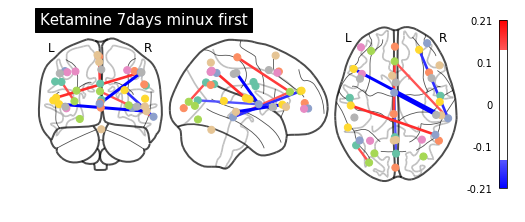

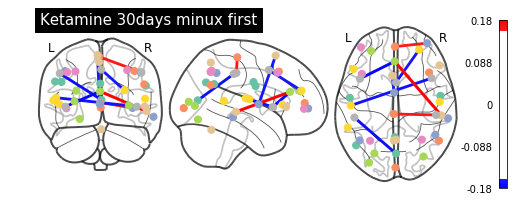

In [18]:
plotting.plot_connectome(np.average(ket2_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 7days minux first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minux first")



In [19]:
# let do midazolam
mid1_series = timeSeries(func_files=fileList(midSubList,'1'), confound_files=confList(midSubList, '1'))

mid2_series = timeSeries(func_files=fileList(midSubList,'2'), confound_files=confList(midSubList, '2'))

proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-1/func/sub-1253_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1339.3s, 22.3min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-1/func/sub-1263_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1353.6s, 22.6min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-1/func/sub-1351_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1368.3s, 22.8min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-1/func/sub-1364_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1382.3s, 23.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-1/func/sub-1369_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1396.8s, 23.3min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-1/func/sub-1390_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1411.4s, 23.5min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-1/func/sub-1403_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1425.1s, 23.8min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.1s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1253/ses-2/func/sub-1253_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1438.9s, 24.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-2/func/sub-1263_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1453.0s, 24.2min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-2/func/sub-1351_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1467.3s, 24.5min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-2/func/sub-1364_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1480.7s, 24.7min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-2/func/sub-1369_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1494.7s, 24.9min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-2/func/sub-1390_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1509.4s, 25.2min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-2/func/sub-1403_ses-2_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1522.9s, 25.4min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [20]:
mid3_no1253 = midSubList
print(mid3_no1253)
mid3_no1253.remove('1253')
mid3_series = timeSeries(fileList(mid3_no1253,'3'), confList(mid3_no1253,'3'))

['1253', '1263', '1351', '1364', '1369', '1390', '1403']
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1263/ses-3/func/sub-1263_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1537.0s, 25.6min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1351/ses-3/func/sub-1351_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1551.5s, 25.9min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1364/ses-3/func/sub-1364_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1565.7s, 26.1min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1369/ses-3/func/sub-1369_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1579.7s, 26.3min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1390/ses-3/func/sub-1390_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1594.4s, 26.6min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
proccessing file /home/oad4/scratch60/kpeOutput/fmriprep/sub-1403/ses-3/func/sub-1403_ses-3_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /home/oad4/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[Memory]1608.1s, 26.8min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [21]:
# build correlation matrix for each time point
mid1_corr = createCorMat(time_series=mid1_series)
mid2_corr = createCorMat(mid2_series)
mid3_corr = createCorMat(mid3_series)

In [22]:
# start contrasting
mid2_mid1 = contFuncs(mid1_corr, mid2_corr)
ket3_ket1 = contFuncs(ket1_corr, ket3_corr)

#mid3_mid1 = np.average(mid3_corr, axis=0) - np.average(mid1_corr, axis = 0) # we do so because the number do not match

#mid3_mid1.shape


In [ ]:
# plotting connectome differences
%matplotlib inline

plotting.plot_connectome(np.average(ket2_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 7days minus first")

plotting.plot_connectome(np.average(ket3_ket1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine 30days minus first")

plotting.plot_connectome(np.average(mid2_mid1, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Midazolam 7days minus first")

#plotting.plot_connectome(mid3_mid1, coords,
 #                        edge_threshold="99%", colorbar=True, title = "midazolam 30days minux first")

plotting.plot_connectome(np.average(ket1_corr,axis=0) -np.average(mid1_corr, axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine - Midazolam 0days")

plotting.plot_connectome(np.average(ket2_corr,axis=0)-np.average(mid2_corr,axis=0), coords,
                         edge_threshold="99%", colorbar=True, title = "Ketamine-Midazolan 7days", output_file='pretty_brain.png')


plotting.show()


In [23]:
# rearrange the array to N,N,subnumber for NBS
ket1Reshape = np.moveaxis(np.array(ket1_corr), 0,-1)
print(ket1Reshape.shape)
ket2Reshape = np.moveaxis(np.array(ket2_corr), 0,-1)
ket3Reshape = np.moveaxis(np.array(ket3_corr), 0,-1)
ket4Reshape = np.moveaxis(np.array(ket4_corr), 0,-1)
mid1Reshape = np.moveaxis(np.array(mid1_corr),0,-1)
mid2Reshape = np.moveaxis(np.array(mid2_corr),0,-1)
mid3Reshape = np.moveaxis(np.array(mid3_corr),0,-1)

#print(mid3Reshape.shape)


(39, 39, 8)


In [232]:
# now we can run NBS
# NBS is taken from: https://github.com/aestrivex/bctpy, can be installed using pip (pip install bctpy)
from bct import nbs
# we compare ket1 and ket3
pval, adj, _ = nbs.nbs_bct(ket1Reshape, ket3Reshape, thresh=2.5, tail='both',k=1500, paired=True, verbose = True)
# check mean p vlue
#np.mean(checkNBS[0])

max component size is 39
estimating null distribution with 1500 permutations
permutation 0 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 1 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 2 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 3 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 4 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 5 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 6 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 7 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 8 of 1500.  Permutation max is 11.0.  Observed max is 39.0.  P-val estimate is 0.000
permutation 9 of 1500.  Permutation max is 26.0.  

permutation 89 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.044
permutation 90 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.044
permutation 91 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 92 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 93 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.043
permutation 94 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 95 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.042
permutation 96 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 97 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.041
permutation 98 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.040
permutation 99 of 150

permutation 179 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.056
permutation 180 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 181 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 182 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 183 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 184 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 185 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 186 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 187 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 188 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation

permutation 267 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 268 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 269 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 270 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.052
permutation 271 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 272 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 273 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 274 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 275 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.051
permutation 276 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.051
permutatio

permutation 356 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.056
permutation 357 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.056
permutation 358 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.056
permutation 359 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.056
permutation 360 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 361 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 362 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 363 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 364 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation 365 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.055
permutation

permutation 446 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 447 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 448 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 449 of 1500.  Permutation max is 9.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 450 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 451 of 1500.  Permutation max is 35.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 452 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 453 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 454 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 455 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation

permutation 536 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 537 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 538 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 539 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 540 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 541 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 542 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 543 of 1500.  Permutation max is 11.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 544 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.057
permutation 545 of 1500.  Permutation max is 36.0.  Observed max is 39.0.  P-val estimate is 0.057
permutatio

permutation 626 of 1500.  Permutation max is 35.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 627 of 1500.  Permutation max is 22.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 628 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 629 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 630 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 631 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 632 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 633 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 634 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 635 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.058
permutatio

permutation 716 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 717 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 718 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 719 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 720 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 721 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 722 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 723 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 724 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 725 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.062
permutatio

permutation 806 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 807 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 808 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 809 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 810 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 811 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 812 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 813 of 1500.  Permutation max is 9.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 814 of 1500.  Permutation max is 37.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 815 of 1500.  Permutation max is 30.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation

permutation 896 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 897 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 898 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 899 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 900 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 901 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 902 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 903 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 904 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 905 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.060
permutatio

permutation 986 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 987 of 1500.  Permutation max is 35.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 988 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 989 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 990 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.063
permutation 991 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 992 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 993 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 994 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 995 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.062
permutatio

permutation 1076 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1077 of 1500.  Permutation max is 32.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1078 of 1500.  Permutation max is 27.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1079 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1080 of 1500.  Permutation max is 15.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1081 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.064
permutation 1082 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.065
permutation 1083 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.065
permutation 1084 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.065
permutation 1085 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.064


permutation 1166 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 1167 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 1168 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 1169 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.062
permutation 1170 of 1500.  Permutation max is 37.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 1171 of 1500.  Permutation max is 24.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 1172 of 1500.  Permutation max is 26.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 1173 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 1174 of 1500.  Permutation max is 14.0.  Observed max is 39.0.  P-val estimate is 0.061
permutation 1175 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.061


permutation 1256 of 1500.  Permutation max is 41.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1257 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1258 of 1500.  Permutation max is 20.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1259 of 1500.  Permutation max is 25.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1260 of 1500.  Permutation max is 16.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1261 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1262 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1263 of 1500.  Permutation max is 7.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1264 of 1500.  Permutation max is 19.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1265 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.060
p

permutation 1346 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1347 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1348 of 1500.  Permutation max is 12.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1349 of 1500.  Permutation max is 8.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1350 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1351 of 1500.  Permutation max is 35.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1352 of 1500.  Permutation max is 23.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1353 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1354 of 1500.  Permutation max is 13.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1355 of 1500.  Permutation max is 29.0.  Observed max is 39.0.  P-val estimate is 0.059
p

permutation 1436 of 1500.  Permutation max is 28.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 1437 of 1500.  Permutation max is 31.0.  Observed max is 39.0.  P-val estimate is 0.058
permutation 1438 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1439 of 1500.  Permutation max is 17.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1440 of 1500.  Permutation max is 21.0.  Observed max is 39.0.  P-val estimate is 0.059
permutation 1441 of 1500.  Permutation max is 40.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1442 of 1500.  Permutation max is 34.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1443 of 1500.  Permutation max is 18.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1444 of 1500.  Permutation max is 36.0.  Observed max is 39.0.  P-val estimate is 0.060
permutation 1445 of 1500.  Permutation max is 33.0.  Observed max is 39.0.  P-val estimate is 0.059


In [239]:
# look at p values and No. of components.
print(pval.shape)
print (pval)
len(pval)
print(adj.shape)

print(adj[0:10])
ad = np.array(adj)
print(ad[:,0:10])
#bct.adjacency_plot_und(adj, coords, tube=False)

(1,)
[0.06066667]
(39, 39)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0

Between 30 days in 1st day Ketamine has different in one components. 
Lets graph it

In [26]:
# lets look at 90 days and first


BCTParamError: Population matrices must be an equal size

In [ ]:
# Lets check Midazolam group


In [ ]:
pvalMid, adjMid, _ = nbs.nbs_bct(mid1Reshape[:,:,:6], mid3Reshape, thresh=2.5, tail='both',k=1000, paired=True, verbose = True)


In [ ]:
print(pvalMid.shape)
print (pvalMid)

Midazolam has no significant change between first day and 7 or 30 days.
Lets check differences between ket and mid.

In [ ]:
pvalKetMid, adjKetMid, _ = nbs.nbs_bct(ket2Reshape, mid2Reshape, thresh=2.5, tail='both',k=1000, paired=False, verbose = True)


In [ ]:
print(pvalKetMid.shape)
print (pvalKetMid)
# no difference between ketamine and midazolam. 


In [316]:
# for the sake of QA we can create histogram plots of correlation matrices

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(f) #, color = 'blue', edgecolor = 'black',
         #bins = int(180/5))

#ket1_corr.hist()
#sns.distplot(f)


(780,)
(780,)
(780,)
(780,)
(780,)
(780,)
(780,)
(780,)


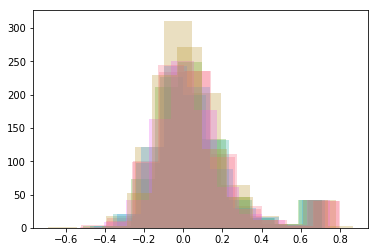

In [31]:
# Run analysis on all ket subjects
#color = sns.cubehelix_palette(len(ket1_corr),8)
#color = sns.palplot(sns.color_palette("RdBu_r", len(ket1_corr)))
sns.set_palette("husl") # set color pallet
correlation_vec = ConnectivityMeasure(kind='partial correlation', vectorize=True) # can choose partial - it might be better
    
# create correlation matrix for each subject
fullVec = []
for time_s in ket3_series:
    cor = correlation_vec.fit_transform([time_s])[0]
    print(cor.shape)
    plt.hist(cor, alpha = 0.3)
    fullVec.append(cor)


In [188]:
# using adjacency matrix - take the real correaltion differences 
# loop through adj matrix
# every time find 1 index it and take actual corelation deltas from Ket3-ket1 matrix (or other of that kind)
ketDeltaA = []
for i in ket3_ket1:
    ketSubjectAdj = []#[np.zeros((39,39))]
    for n,k in zip(ad,i):
        
        # now row by row
        for rAdj, rKet in zip(n,k):
            a = []
            
            if rAdj!=0:
                a.insert(len(a),rKet) # inserting another element
            else:
                a.insert(len(a),0)
            ketSubjectAdj.insert(len(ketSubjectAdj),a)
    ketDeltaA.append(np.array(ketSubjectAdj))#.reshape(-1)) # flatten the ,1 matrix to vector

In [266]:
ketDeltaA = []
b = ad
for ket in (ket3_ket1):
    #print(f"New Array {ket}")
    #ketSubjectAdj = []
    g = np.zeros([39,39])
    print(ket[b!=0])
    g[b!=0] = ket[b!=0]
    #print (b[0])
    #print(ket3_ket1[n,0])
    #b[b!=0] = ket[b!=0]
    ketDeltaA.insert(len(ketDeltaA),g)
    
    #ketDeltaA.append(ketSubjectAdj)

    
np.array(ketDeltaA).shape  
#print(f"First {np.array(ketDeltaA)[0,:,0:10]}")
#print(f"Sec {np.array(ketDeltaA)[1,:,0:10]}")
    
# This vectors (one per subject) will use for regression analysis, after we exclude all zeros from them (see below)

[-0.03983419 -0.0293757   0.03759542 -0.21382685 -0.18926696  0.17623788
 -0.24591062  0.09660732 -0.19541844  0.0755849  -0.17263693  0.00862686
  0.33254886  0.07018976  0.24000594 -0.18813713  0.24077527 -0.09071133
  0.00109019  0.07497553  0.01829464  0.32075524 -0.09899265  0.00456516
 -0.057328   -0.04917273 -0.21097772  0.15521836  0.15358975  0.15307276
  0.03271684 -0.26708666 -0.11334492 -0.08908983  0.04386594  0.06059105
  0.11982872  0.11252264  0.04129635 -0.29651066  0.20539075 -0.1195279
  0.09233415  0.08252802  0.16290471 -0.0443337  -0.14679196  0.24011121
  0.00123395 -0.20236284  0.0755849   0.14171368 -0.12533686  0.20539075
 -0.1215636   0.16290471 -0.09063423  0.01140383  0.17924806  0.0742061
  0.12953977  0.01102647 -0.0443337   0.15154275 -0.00643213  0.0742061
 -0.09063423  0.17924806 -0.1195279   0.05206418 -0.01793038  0.13927375
 -0.00810675 -0.03983419  0.09233415  0.02395743  0.07374428 -0.14679196
  0.24011121 -0.24483092 -0.10087672  0.00123395  0.05

(8, 39, 39)

In [231]:
p = ([1,2,3],[4,5,6])
q = ([1,2,7],[4,5,9])
x = ([0,0,1],[0,0,1])
a = [p,q]
print(np.array(x).shape)
x= np.array(x)
p = np.array(p)
for m in a:
    print(a)
    #x[x!=0] = m[x!=0]

(2, 3)
[([1, 2, 3], [4, 5, 6]), ([1, 2, 7], [4, 5, 9])]
[([1, 2, 3], [4, 5, 6]), ([1, 2, 7], [4, 5, 9])]


In [268]:
print(ketDeltaA)

[array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03759542,  0.        , -0.21382685, ...,  0.11252264,
         0.04129635, -0.29651066],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06536685,  0.        , -0.15885698, ..., -0.1932166 ,
         0.19155811,  0.05091283],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        

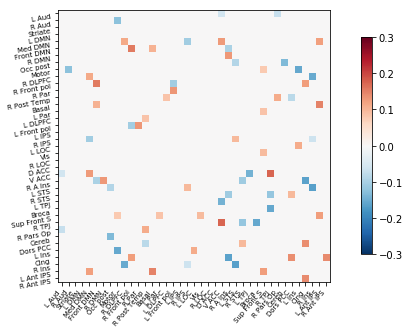

In [301]:
# We will build a simple average matrix (ket3 - ket1) according to the adjacency matrix (39,39) in order to vizualize
# results on the nodes themselves
ket3_1_average = np.average(np.array(ket3_ket1), axis = 0)

# now we replace all 1 in adj to real values and zeros will remain zeros
j = adj
j[j!=0] = ket3_1_average[j!=0] # replacing j values in real difference instead of 1
# now we can plot

plotting.plot_connectome(j, coords,
                        edge_threshold="98%", colorbar=True, output_file="Ket3_vsKet1.png")


plotting.plot_matrix(j, labels=labels, colorbar=True,
                     vmax=0.3, vmin=-0.3)

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/seaborn/palettes.py:777: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  pal = _ColorPalette(pal(np.linspace(0, 1, n_colors)))


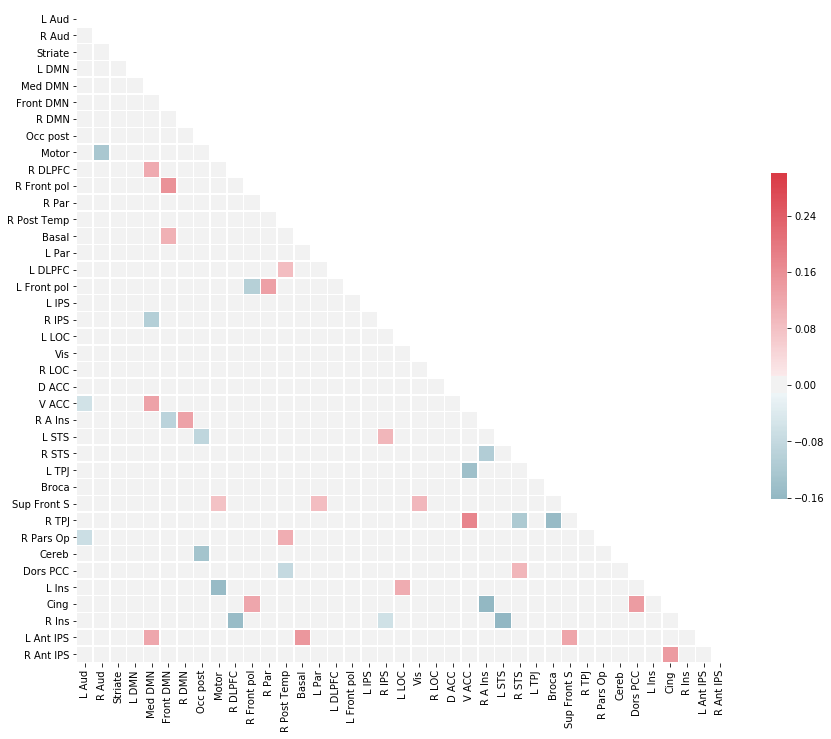

In [300]:
# this is a small snippet of code that takes the adajecnt's matrix that was created before and present it in diagonal 
# correlation matrix. 
#  change it into dataframe to add labels (using atlas labels)
import pandas as pd
d = pd.DataFrame(data=j,
                 columns=labels, index=labels)

mask = np.zeros_like(d, dtype=np.bool) # masking half
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns_plot = sns.heatmap(d, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



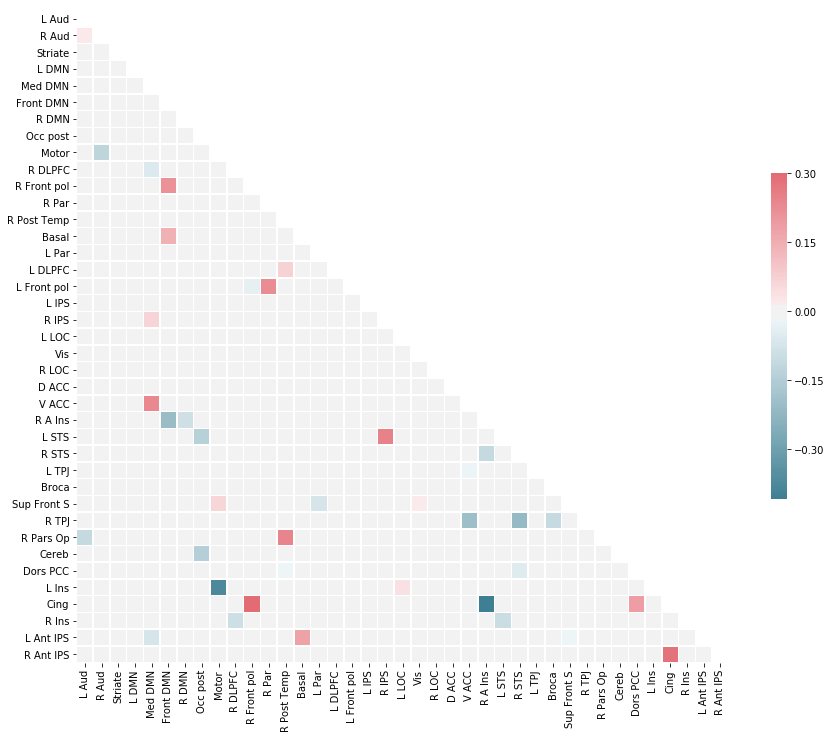

In [285]:
# now - just to make sure I understand which place in the vector (78 because its 39*2) if for which correlation
k = ad
k[k==1] = ket3_ket1[0][k==1] # replacing j values in real difference instead of 1

sub8 = pd.DataFrame(data=k,
                 columns=labels, index=labels)

mask = np.zeros_like(sub8, dtype=np.bool) # masking half
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(sub8, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [294]:
#print(ket3_ket1[1,:,0:15])

#print(k[:,38])
v = np.array(vecKetamin)
print(np.array(ketDeltaA).shape)
print(f"KDeltaArray {np.array(ketDeltaA)[0,:,[38]]}")
print(np.array(vecKetamin)[0])

#print(f"First Ket {ket1_corr[0][:,1:10]}")
#print(f"Third ket {ket3_corr[0][:,1:10]}")
#print(f"Substract {ket3_ket1[:,1:10]}")

(8, 39, 39)
KDeltaArray [[ 0.         -0.29651066  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.0968499
   0.          0.          0.        ]]
[-0.03983419 -0.0293757   0.03759542 -0.21382685 -0.18926696  0.17623788
 -0.24591062  0.09660732 -0.19541844  0.0755849  -0.17263693  0.00862686
  0.33254886  0.07018976  0.24000594 -0.18813713  0.24077527 -0.09071133
  0.00109019  0.07497553  0.01829464  0.32075524 -0.09899265  0.00456516
 -0.057328   -0.04917273 -0.21097772  0.15521836  0.15358975  0.15307276
  0.03271684 -0.26708666 -0.11334492 -0.08908983  0.04386594  0.06059105
  0.11982872  0.11252264  0.04129635 -0.29651066  0.20539075 -0.1195279
  0.09233415  0.0825280

In [271]:
# need to build regression model according to this vector for each subject
# change from matrix to vector
vecKetamin = [] # vector of all edges per subject
for i in ketDeltaA:
    a = np.array(i).reshape(-1) # reshaping subject matrix to vector
    #print(a[a!=0]) 
    vecKetamin.append(a[a!=0]) # appending everything that's not zero 
np.array(vecKetamin).shape # shape of vector (subjects,length)

(8, 115)

In [54]:
# lets run regression model to try and predict PCL scores with connectivity vector
# first load up pcl data
kpe_dat = pd.read_excel('/home/oad4/Documents/kpe_analysis/KPEIHR0009_data_all_scored.xlsx', index_col ="scr_id")


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [55]:
import statistics 
# subset the data frame
kpe_pcl = kpe_dat[['pcl5_total_visit7','pcl5_total_screen', 'pcl5_total_followup1','pcl5_total_followup2']] 
# remove NaN's from FU2
for i,n in enumerate(kpe_pcl['pcl5_total_followup2']):
    if  pd.isna(n) == True:
        print('nan')
        print(kpe_pcl['pcl5_total_followup2'][i])
        kpe_pcl['pcl5_total_followup2'][i]= np.nanmean(kpe_pcl['pcl5_total_followup2'])
    
    
print(kpe_pcl)
np.nanmean(kpe_pcl['pcl5_total_followup2'])

nan
nan
nan
nan
nan
nan


/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


         pcl5_total_visit7  pcl5_total_screen  pcl5_total_followup1  \
scr_id                                                                
KPE008                  61                 51                  56.0   
KPE1223                 50                 39                  42.0   
KPE1253                 58                 58                  33.0   
KPE1263                 56                 21                  37.0   
KPE1293                  6                 33                   8.0   
KPE1307                 41                 56                  45.0   
KPE1315                  8                 40                   NaN   
KPE1322                 22                 45                  38.0   
KPE1339                 65                 68                  46.0   
KPE1343                 20                 28                  20.0   
KPE1351                 26                 40                  33.0   
KPE1356                 56                 61                  52.0   
KPE136

35.13333333333333

In [56]:
# now lets build regression model
# Y = pcl score at FU2
# X's = vector of edges from each subject
kpe_data_pcl = kpe_pcl.loc[['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223']]
print(kpe_data_pcl)

         pcl5_total_visit7  pcl5_total_screen  pcl5_total_followup1  \
scr_id                                                                
KPE008                  61                 51                  56.0   
KPE1293                  6                 33                   8.0   
KPE1307                 41                 56                  45.0   
KPE1322                 22                 45                  38.0   
KPE1339                 65                 68                  46.0   
KPE1343                 20                 28                  20.0   
KPE1387                 46                 32                  48.0   
KPE1223                 50                 39                  42.0   

         pcl5_total_followup2  
scr_id                         
KPE008                   49.0  
KPE1293                   3.0  
KPE1307                  20.0  
KPE1322                  27.0  
KPE1339                  67.0  
KPE1343                  19.0  
KPE1387                  39.0  
K

In [272]:
su = ['KPE008','KPE1293','KPE1307','KPE1322','KPE1339','KPE1343','KPE1387','KPE1223']

kpe_matrix_dat = pd.DataFrame(vecKetamin, index=su)
print(kpe_matrix_dat.iloc[:,0:39])
# now we have flatten the matrix. 
# Remember, we now have double of everything, saw basically should split it in half. 


               0         1         2         3         4         5         6   \
KPE008  -0.039834 -0.029376  0.037595 -0.213827 -0.189267  0.176238 -0.245911   
KPE1293  0.030739 -0.080540 -0.065367 -0.158857 -0.046296  0.142464 -0.007231   
KPE1307 -0.151557  0.088885  0.152226 -0.184114  0.205597 -0.169984 -0.011736   
KPE1322 -0.014385 -0.105614 -0.243054  0.374626  0.032019  0.035609  0.084222   
KPE1339 -0.102304 -0.159886  0.080842  0.179623  0.042317 -0.189074 -0.166976   
KPE1343 -0.086554 -0.051566 -0.124393 -0.132621 -0.032468 -0.272525  0.030901   
KPE1387 -0.112390 -0.112897 -0.071055 -0.133951 -0.075742  0.130957  0.054832   
KPE1223  0.012349 -0.110623  0.021965  0.109018 -0.000850 -0.119722 -0.009793   

               7         8         9   ...        29        30        31  \
KPE008   0.096607 -0.195418  0.075585  ...  0.153073  0.032717 -0.267087   
KPE1293 -0.122008 -0.203802 -0.081088  ...  0.030747  0.139441  0.158085   
KPE1307 -0.019218  0.155985 -0.192696  ...

In [320]:
import statsmodels.api as sm

X = kpe_matrix_dat.iloc[:,0:5] #kpe_matrix_dat[1]
y = kpe_data_pcl["pcl5_total_followup2"]

X = sm.add_constant(X)
# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     pcl5_total_followup2   R-squared:                       0.972
Model:                              OLS   Adj. R-squared:                  0.902
Method:                   Least Squares   F-statistic:                     13.94
Date:                  Wed, 08 May 2019   Prob (F-statistic):             0.0683
Time:                          18:44:20   Log-Likelihood:                -20.735
No. Observations:                     8   AIC:                             53.47
Df Residuals:                         2   BIC:                             53.95
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.8208      5.355

/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/gpfs/ysm/project/oad4/conda_envs/py37_dev/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<bound method LikelihoodModelResults.cov_params of <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x2ae13e2a06a0>>

In [275]:
from sklearn import linear_model

lm = linear_model.LinearRegression()

X = kpe_matrix_dat #kpe_matrix_dat[1]
y = kpe_data_pcl["pcl5_total_followup2"]

# define the data/predictors as the pre-set feature names  
#df = pd.DataFrame(kpe_matrix_dat)


print(X.shape)
print(y.shape)
model = lm.fit(X,y)

(8, 115)
(8,)


In [276]:
predictions = lm.predict(X)

In [277]:
print(predictions)

[49.  3. 20. 27. 67. 19. 39. 49.]


In [278]:
lm.score(X,y)
# This leads to perfect prediction. So lets split data for test-retest

1.0

In [279]:
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)



(6, 115) (6,)
(2, 115) (2,)


In [280]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [281]:
predictions

array([39.64903041, 44.19329881])

Text(0, 0.5, 'Predictions')

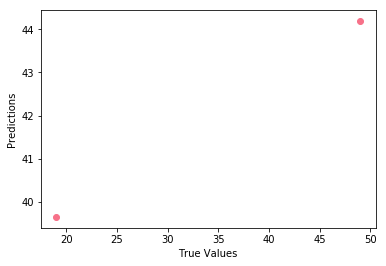

In [282]:
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [283]:
model.score(X_test, y_test)
# prediction is not great

0.001140370544000624